In [18]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.filters
import pandas as pd  

# Step 1: Recording Audio

In [19]:
# Recording parameters
fs = 16000  # Sampling frequency (16 kHz)
duration = 5  # Duration in seconds

print("Recording...")
audio = sd.rec(int(fs * duration), samplerate=fs, channels=1, dtype=np.float32)
sd.wait()  # Wait until recording finishes
print("Recording complete.")

# Save recording
wav.write("recorded_audio.wav", fs, audio)
print("Audio saved as 'recorded_audio.wav'")

Recording...
Recording complete.
Audio saved as 'recorded_audio.wav'


# Audio Properties

In [20]:
# Load recorded audio
fs, signal = wav.read("recorded_audio.wav")

# Convert to mono if stereo
if len(signal.shape) > 1:
    signal = signal[:, 0]
    print("Converted stereo to mono")

# Print audio properties
print(f"\nAudio Properties:")
print(f"Sampling rate: {fs} Hz")
print(f"Duration: {len(signal)/fs:.2f} seconds")
print(f"Number of samples: {len(signal)}")
print(f"Max amplitude: {np.max(signal):.4f}")
print(f"Min amplitude: {np.min(signal):.4f}")

# Normalize signal
signal = signal / np.max(np.abs(signal))

# Print first 10 normalized samples (X[n])
print("\nFirst 10 normalized samples (X[n]):")
for i in range(10):
    print(f"X[{i}] = {signal[i]:.6f}")

# Print some sample values from different parts of the signal
print("\nSample values at different positions:")
positions = [0, len(signal)//4, len(signal)//2, 3*len(signal)//4, len(signal)-1]
for pos in positions:
    print(f"X[{pos}] = {signal[pos]:.6f} (at {pos/fs:.2f} seconds)")


Audio Properties:
Sampling rate: 16000 Hz
Duration: 5.00 seconds
Number of samples: 80000
Max amplitude: 0.0759
Min amplitude: -0.0706

First 10 normalized samples (X[n]):
X[0] = 0.000000
X[1] = 0.000000
X[2] = -0.000402
X[3] = 0.000000
X[4] = 0.000000
X[5] = 0.000000
X[6] = 0.000000
X[7] = -0.000402
X[8] = 0.000000
X[9] = 0.000000

Sample values at different positions:
X[0] = 0.000000 (at 0.00 seconds)
X[20000] = 0.000000 (at 1.25 seconds)
X[40000] = -0.000402 (at 2.50 seconds)
X[60000] = 0.000402 (at 3.75 seconds)
X[79999] = 0.000000 (at 5.00 seconds)


# Step 2: Pre-emphasis Filtering

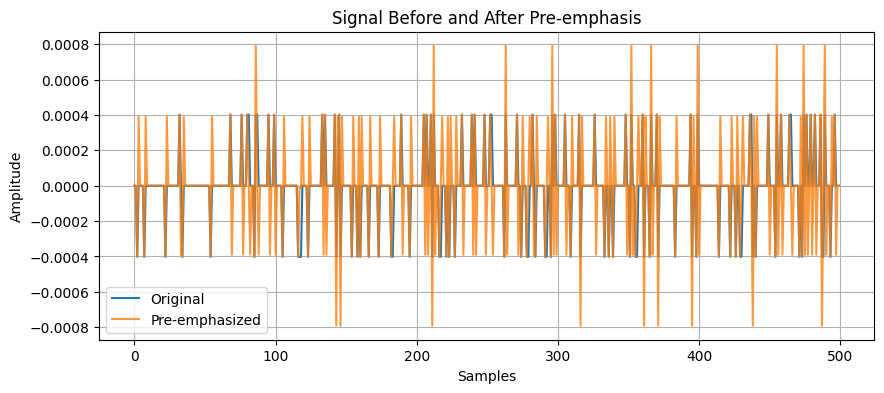

In [21]:
# Apply pre-emphasis filter (α=0.97)
alpha = 0.97
pre_emphasized = np.append(signal[0], signal[1:] - alpha * signal[:-1])

# Plot comparison
plt.figure(figsize=(10, 4))
plt.plot(signal[:500], label="Original")
plt.plot(pre_emphasized[:500], label="Pre-emphasized", alpha=0.8)
plt.title("Signal Before and After Pre-emphasis")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# Save pre-emphasized audio
wav.write("pre_emphasized_audio.wav", fs, (pre_emphasized * 32767).astype(np.int16))


#  Step 3: Framing 

Total frames: 499, Frame size: 400


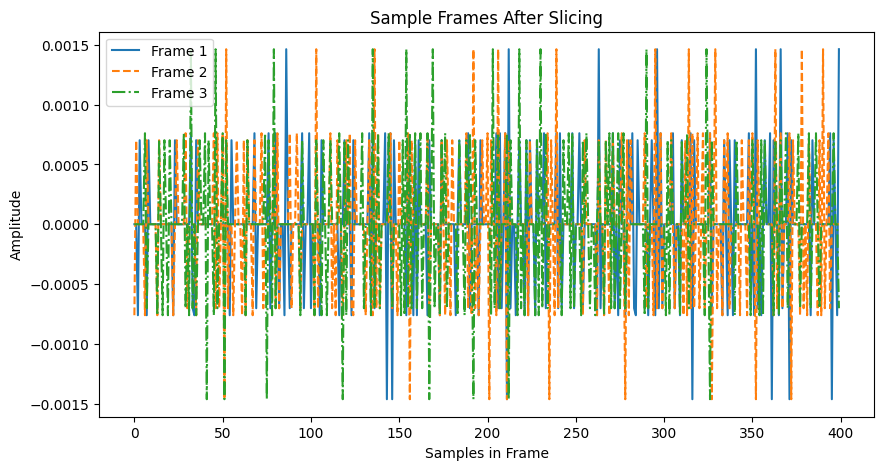

In [22]:

# Load pre-emphasized audio
fs, signal = wav.read("pre_emphasized_audio.wav")

# Convert to mono if stereo
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Normalize signal for better visualization
signal = signal / np.max(np.abs(signal))

# Define frame parameters
frame_size = 0.025  # 25ms per frame
frame_stride = 0.01  # 10ms overlap

# Convert from seconds to samples
frame_length = int(fs * frame_size)  # 400 samples per frame
frame_step = int(fs * frame_stride)  # 160 samples step

# Calculate number of frames
num_frames = int(np.ceil((len(signal) - frame_length) / frame_step)) + 1

# Pad the signal if necessary
pad_length = (num_frames - 1) * frame_step + frame_length
pad_signal = np.append(signal, np.zeros(pad_length - len(signal)))

# Extract frames using slicing
frames = np.lib.stride_tricks.as_strided(
    pad_signal, 
    shape=(num_frames, frame_length), 
    strides=(frame_step * pad_signal.itemsize, pad_signal.itemsize)
)

print(f"Total frames: {frames.shape[0]}, Frame size: {frames.shape[1]}")

# Plot a few frames
plt.figure(figsize=(10, 5))
plt.plot(frames[0], label="Frame 1", linestyle="-")
plt.plot(frames[1], label="Frame 2", linestyle="--")
plt.plot(frames[2], label="Frame 3", linestyle="-.")
plt.xlabel("Samples in Frame")
plt.ylabel("Amplitude")
plt.title("Sample Frames After Slicing")
plt.legend()
plt.show()


# Speech Signal Processing: Silence Removal Using Energy and Zero Crossing Rate (ZCR)

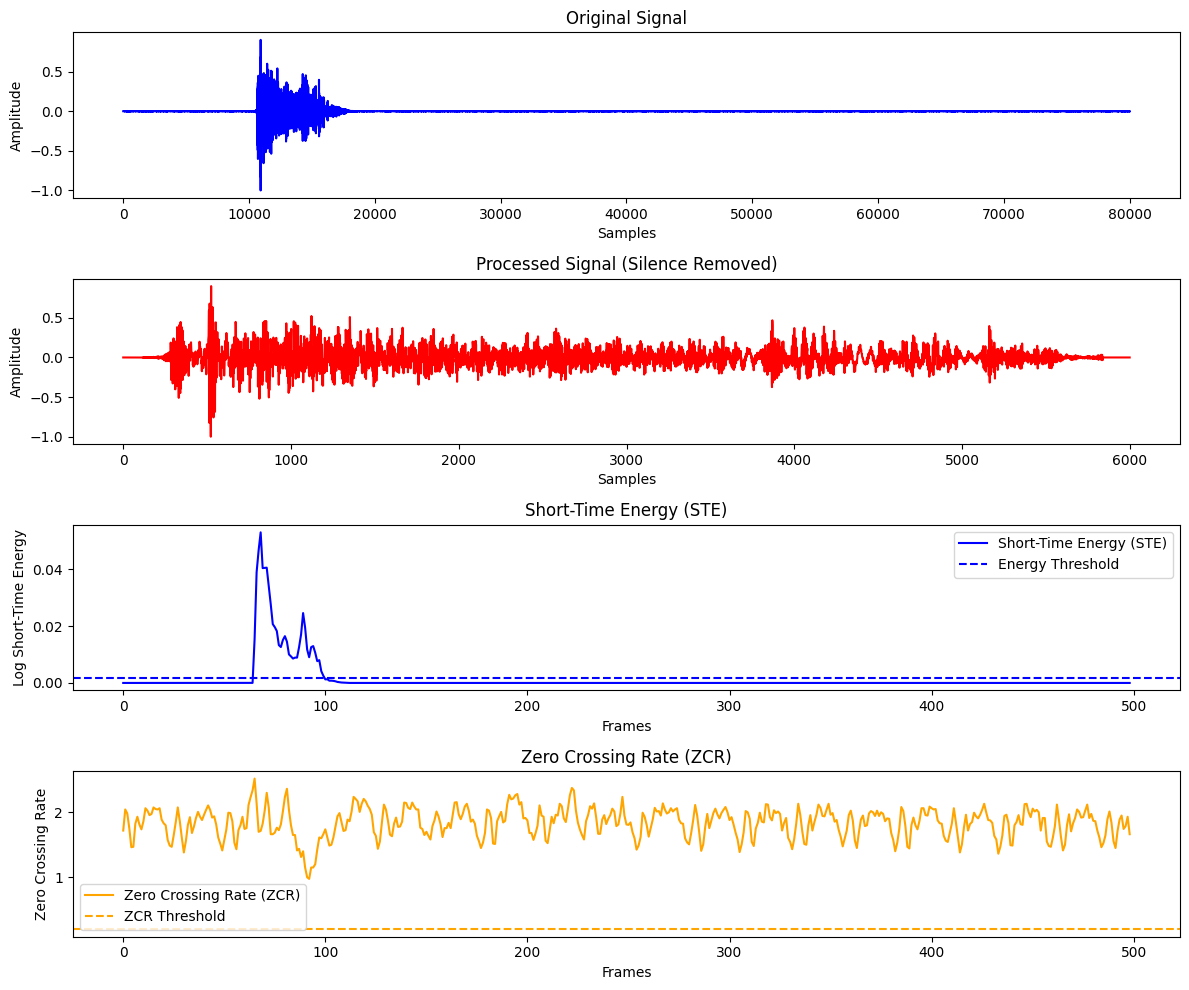

'output_zcr.wav'

In [23]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def process_audio_and_plot(input_file, output_file, frame_size=0.025, frame_stride=0.01, energy_thresh=0.02, zcr_thresh=0.1):
    # 1. Load the audio file
    fs, signal = wav.read(input_file)
    if len(signal.shape) > 1:
        signal = signal[:, 0]  # Convert to mono if stereo
    signal = signal / np.max(np.abs(signal))  # Normalize signal

    # 2. Frame segmentation
    frame_length = int(fs * frame_size)
    frame_step = int(fs * frame_stride)
    num_frames = int(np.ceil((len(signal) - frame_length) / frame_step)) + 1
    pad_length = (num_frames - 1) * frame_step + frame_length
    pad_signal = np.append(signal, np.zeros(pad_length - len(signal)))

    frames = np.lib.stride_tricks.as_strided(
        pad_signal,
        shape=(num_frames, frame_length),
        strides=(frame_step * pad_signal.itemsize, pad_signal.itemsize)
    )

    # 3. Compute Short-Time Energy (STE) and Zero Crossing Rate (ZCR)
    frame_energies = np.sum(frames ** 2, axis=1) / frame_length
    zcr = np.array([np.sum(np.abs(np.diff(np.sign(frame)))) / frame_step for frame in frames])

    # 4. Set thresholds
    energy_threshold = energy_thresh * np.max(frame_energies)
    zcr_threshold = zcr_thresh

    # 5. Detect silent frames
    silent_frames = (frame_energies < energy_threshold) & (zcr > zcr_threshold)
    non_silent_frames = frames[~silent_frames]

    # 6. Reconstruct signal after silence removal
    output_signal = np.zeros(non_silent_frames.shape[0] * frame_step + frame_length)
    for i, frame in enumerate(non_silent_frames):
        start = i * frame_step
        end = start + frame_length
        output_signal[start:end] += frame

    output_signal = output_signal / np.max(np.abs(output_signal))  # Normalize output

    # 7. Save the processed file
    wav.write(output_file, fs, (output_signal * 32767).astype(np.int16))

    # 8. Plot results
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))

    # Plot original signal
    axes[0].plot(signal, color='blue')
    axes[0].set_title("Original Signal")
    axes[0].set_xlabel("Samples")
    axes[0].set_ylabel("Amplitude")

    # Plot processed signal (silence removed)
    axes[1].plot(output_signal, color='red')
    axes[1].set_title("Processed Signal (Silence Removed)")
    axes[1].set_xlabel("Samples")
    axes[1].set_ylabel("Amplitude")

    # Plot Short-Time Energy (STE)
    axes[2].plot(np.log1p(frame_energies), label="Short-Time Energy (STE)", color='blue')
    axes[2].axhline(y=np.log1p(energy_threshold), color='blue', linestyle='dashed', label="Energy Threshold")
    axes[2].set_title("Short-Time Energy (STE)")
    axes[2].set_xlabel("Frames")
    axes[2].set_ylabel("Log Short-Time Energy")
    axes[2].legend()

    # Plot Zero Crossing Rate (ZCR)
    axes[3].plot(zcr, label="Zero Crossing Rate (ZCR)", color='orange')
    axes[3].axhline(y=zcr_threshold, color='orange', linestyle='dashed', label="ZCR Threshold")
    axes[3].set_title("Zero Crossing Rate (ZCR)")
    axes[3].set_xlabel("Frames")
    axes[3].set_ylabel("Zero Crossing Rate")
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    return output_file

# Run the function with appropriate parameters
process_audio_and_plot("pre_emphasized_audio.wav", "output_zcr.wav", energy_thresh=0.03, zcr_thresh=0.2)


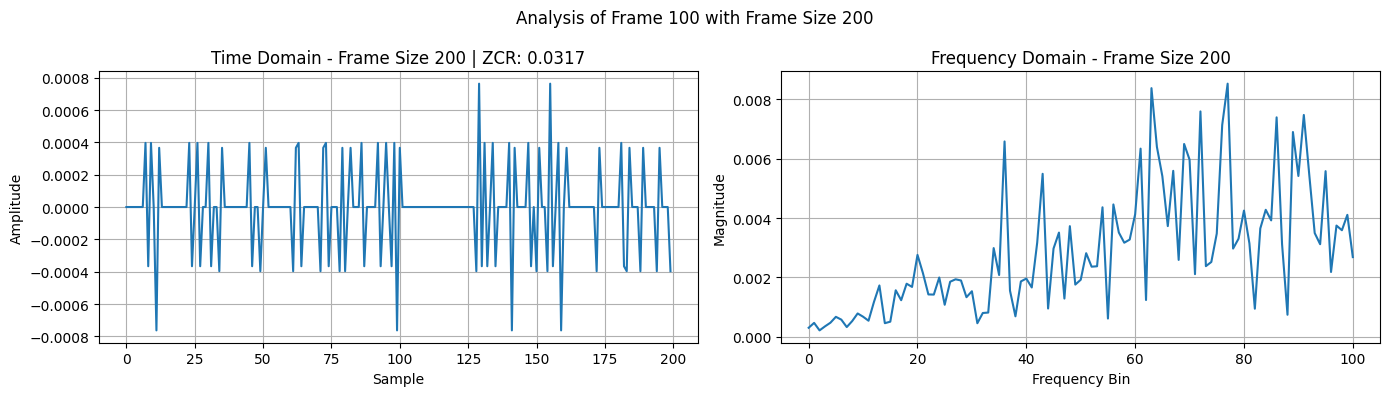

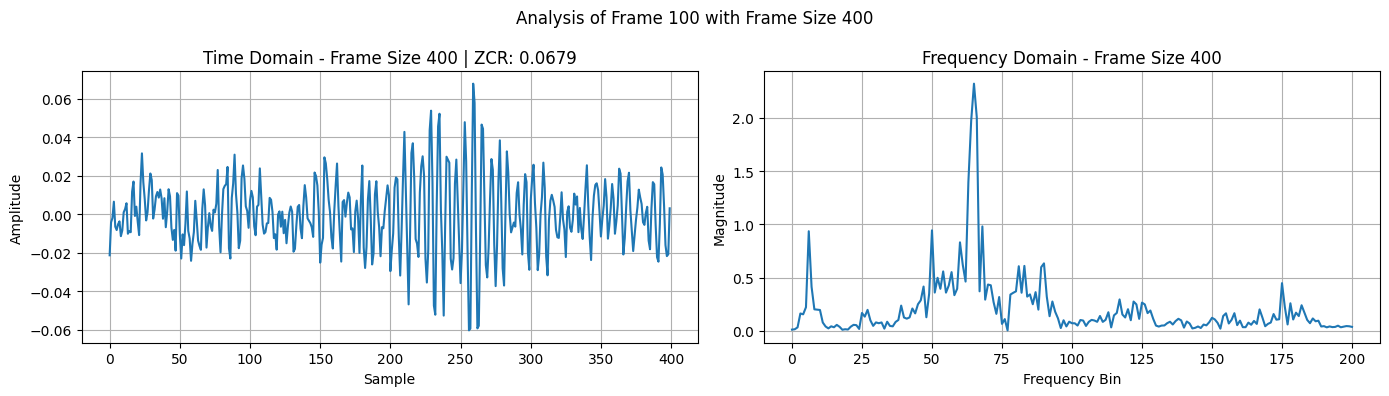

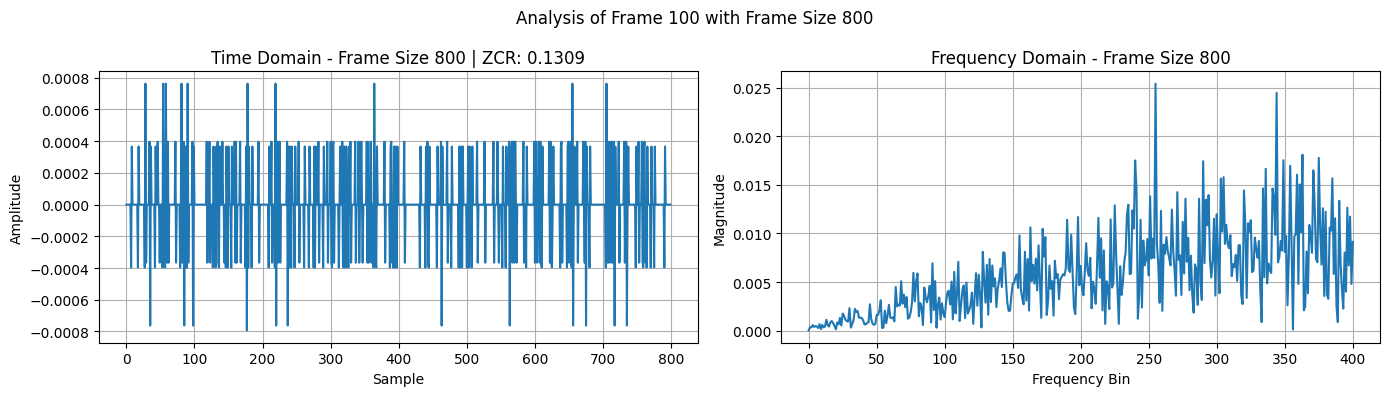

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf

# Load the audio file
filename = 'pre_emphasized_audio.wav'
y, sr = sf.read(filename)

# Try different frame sizes
frame_sizes = [200, 400, 800]
hop_ratio = 0.4  # The hop ratio between frames (can be adjusted later)

# Fixed frame index for comparison
frame_index = 100  # This is used to test the same frame across different frame sizes

for frame_size in frame_sizes:
    hop_size = int(frame_size * hop_ratio)

    # Frame the signal into overlapping windows
    frames = librosa.util.frame(y, frame_length=frame_size, hop_length=hop_size).T
    if frame_index >= len(frames):
        print(f"❌ Frame index {frame_index} exceeds the number of frames ({len(frames)}) for frame_size={frame_size}")
        continue

    selected_frame = frames[frame_index]

    # Calculate Zero Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(selected_frame.reshape(1, -1)))

    # Calculate the FFT (Fast Fourier Transform)
    fft_vals = np.fft.rfft(selected_frame)
    fft_mag = np.abs(fft_vals)

    # Plot the results
    plt.figure(figsize=(14, 4))
    
    # Time Domain Plot
    plt.subplot(1, 2, 1)
    plt.plot(selected_frame)
    plt.title(f"Time Domain - Frame Size {frame_size} | ZCR: {zcr:.4f}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Frequency Domain Plot (Magnitude of FFT)
    plt.subplot(1, 2, 2)
    plt.plot(fft_mag)
    plt.title(f"Frequency Domain - Frame Size {frame_size}")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.grid(True)

    # Overall plot title
    plt.suptitle(f"Analysis of Frame {frame_index} with Frame Size {frame_size}")
    plt.tight_layout()
    plt.show()


Based on the three analyses with frame sizes 200, 400, and 800, here's a comparison and recommendation:

### Observations:

1. **Zero Crossing Rate (ZCR)**: 
   - Frame 200: ZCR = 0.0317 (lowest)
   - Frame 400: ZCR = 0.0679 
   - Frame 800: ZCR = 0.1309 (highest)
   - The ZCR increases with frame size, suggesting more zero crossings are captured in larger frames.

2. **Time Domain Analysis**:
   - Frame 200 shows the finest detail in the waveform
   - Frame 800 shows a smoother, more averaged view of the signal
   - Frame 400 is a middle ground between detail and smoothness

3. **Frequency Domain Analysis**:
   - Frame 200 has limited frequency resolution (wider bins)
   - Frame 800 provides the best frequency resolution (narrower bins)
   - Frame 400 again provides a middle ground

### Recommendation:

**Best Frame Size: 400** (for this particular audio analysis)

### Why 400?

1. **Balance Between Time and Frequency Resolution**:
   - Frame 200 gives good time resolution but poor frequency resolution
   - Frame 800 gives excellent frequency resolution but poor time resolution
   - Frame 400 provides a good compromise between both

2. **Practical Considerations**:
   - For speech analysis, frames of 20-40ms are typical (400 samples at 16kHz is 25ms)
   - Larger frames may miss transient features
   - Smaller frames may not capture enough spectral information

3. **ZCR Value**:
   - The ZCR of 0.0679 seems more representative than the extremes of the other frames

### Additional Notes:
- The best frame size depends on your specific application:
  - If you need to detect quick transients, a smaller frame (200) might be better
  - If spectral analysis is more important, consider the larger frame (800)
- You might also want to experiment with frame sizes between 400-600 to find the optimal balance
- The hop ratio of 0.4 seems reasonable, but you could try 0.5 for less overlap if processing speed is a concern

Would you like me to suggest any additional analyses to help determine the optimal frame size?

 # Step 4:Windowing

Windowed Frames (2D Array):
[[   0.            0.            0.         ...  181.79692291
   -39.14788956 -104.72      ]
 [  -5.6           7.52536118   -4.17186231 ...  350.27597768
   216.3141055   195.76      ]
 [ 491.68       1001.43343662 -938.82947567 ... -326.92959437
   193.57790789  627.6       ]
 ...
 [-186.24        -76.13423921   65.78705948 ...   77.50036519
   -21.13505694  -66.        ]
 [  18.56         69.4895054    35.05968902 ...  -33.1342141
   -88.22285132  -12.        ]
 [ -71.28        -14.00998093   -6.09733722 ...    0.
     0.            0.        ]]

First 5 Rows of Windowed Frames (Better View):
      0            1           2           3           4           5    \
0    0.00     0.000000    0.000000    0.644106   -0.566386   -0.651401   
1   -5.60     7.525361   -4.171862    0.966159    2.346456   17.587830   
2  491.68  1001.433437 -938.829476  217.385694  947.239816 -444.092711   
3 -170.56   128.811767  154.599590  165.052101  161.662694  291.990551   

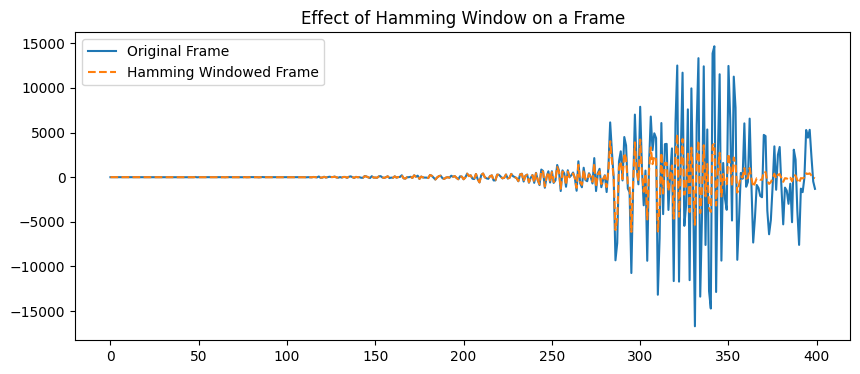

In [24]:
# Load framed signal from the previous step
fs, signal = wav.read("output_zcr.wav")

# Convert to mono if stereo
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Define frame parameters
frame_size = 0.025  # 25ms
frame_stride = 0.01  # 10ms overlap
frame_length = int(fs * frame_size)  # 400 samples per frame
frame_step = int(fs * frame_stride)  # 160 samples step

# Calculate number of frames
num_frames = int(np.ceil((len(signal) - frame_length) / frame_step)) + 1

# Pad the signal if necessary
pad_length = (num_frames - 1) * frame_step + frame_length
pad_signal = np.append(signal, np.zeros(pad_length - len(signal)))

# Extract frames
frames = np.lib.stride_tricks.as_strided(
    pad_signal, 
    shape=(num_frames, frame_length), 
    strides=(frame_step * pad_signal.itemsize, pad_signal.itemsize)
)

# Apply Hamming Window
hamming_window = np.hamming(frame_length)
windowed_frames = frames * hamming_window

# Print the 2D array after applying the Hamming window
print("Windowed Frames (2D Array):")
print(windowed_frames)

# Optional: Convert to pandas DataFrame for better visualization
df = pd.DataFrame(windowed_frames)
print("\nFirst 5 Rows of Windowed Frames (Better View):")
print(df.head())

# Plot a single frame before and after windowing
plt.figure(figsize=(10, 4))
plt.plot(frames[0], label="Original Frame")
plt.plot(windowed_frames[0], label="Hamming Windowed Frame", linestyle='--')
plt.legend()
plt.title("Effect of Hamming Window on a Frame")
plt.show()

# Step 5: Discrete Fourier Transform (DFT)


FFT Frames (After DFT):
[[  753.40248472   +0.j         -1131.77289241 +220.92399168j
    823.59034401-1585.31264933j ...   111.87496766-2215.81700659j
   1620.98582237+1778.49344627j -2324.5298727    +0.j        ]
 [ -503.93861025   +0.j          1158.31967243-2722.95580059j
  -3918.47682727-1529.49431495j ...  3348.55479622+3561.90423922j
   3095.03036852-4675.32064206j -6630.01644056   +0.j        ]
 [-8252.73270538   +0.j          5867.33573951-3975.95495112j
  -4718.33061962  -77.82503958j ...   165.50401821+1836.95114492j
  -1677.1236859 -2002.69575027j -2499.49817539   +0.j        ]
 ...
 [  945.11251865   +0.j         -1245.82081582 -208.50208025j
   2079.01447183 +406.15467324j ...   869.88563665 -347.86917241j
  -1073.76806308 +103.988733j     738.06916785   +0.j        ]
 [-1265.52771966   +0.j          2126.54135036  +33.20448778j
  -1546.66331545-1496.15397635j ...    16.81104582 +282.9994681j
    -52.25442459 +442.14967165j   484.54059955   +0.j        ]
 [ -572.86315438

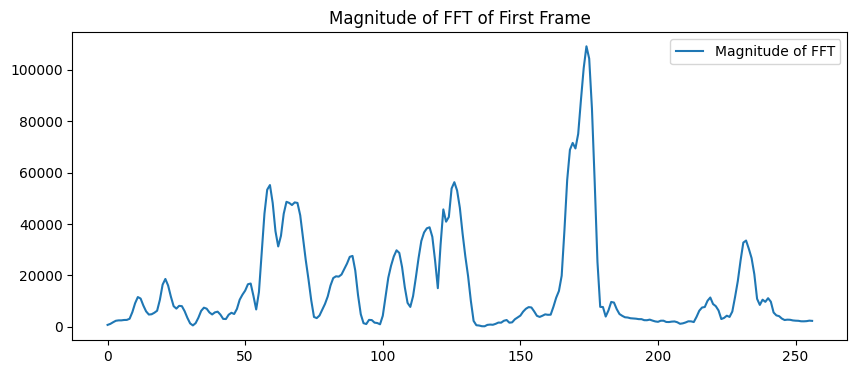

In [25]:
# Perform FFT on each frame
NFFT = 512  # FFT size
fft_frames = np.fft.rfft(windowed_frames, NFFT)

# Print the FFT result (complex values)
print("\nFFT Frames (After DFT):")
print(fft_frames)

# Optional: Convert to pandas DataFrame for better visualization of complex values
fft_df = pd.DataFrame(np.abs(fft_frames))  # Magnitude of the FFT
print("\nFirst 5 Rows of FFT Frames (Magnitude):")
print(fft_df.head())

# Plot the magnitude of the FFT for the first frame
plt.figure(figsize=(10, 4))
plt.plot(np.abs(fft_frames[0]), label="Magnitude of FFT")
plt.title("Magnitude of FFT of First Frame")
plt.legend()
plt.show()


# Step 5: Power Spectrum Calculation

In [26]:
power_spectrum = (1.0 / NFFT) * (np.abs(fft_frames) ** 2)

# Step 6: Mel Filter Bank Application

In [27]:
# Number of Mel filters
num_mel_filters = 40

# Mel filter bank
mel_filter_bank = librosa.filters.mel(sr=fs, n_fft=NFFT, n_mels=num_mel_filters)

# Apply Mel filter bank to the power spectrum
mel_energy = np.dot(mel_filter_bank, power_spectrum.T)


Mel Spectrogram (Linear Scale of Mel Filter Bank Energy)

Array after Mel Filter Bank:
[[2.45023817e+02 2.81789355e+03 5.85795324e+03 ... 4.62612653e+02
  2.75425184e+02 5.63398899e+01]
 [3.96726072e+02 6.43340630e+03 2.12865377e+04 ... 2.13886382e+03
  1.35854840e+03 2.27172600e+02]
 [6.24173517e+02 9.05077815e+04 5.25131449e+05 ... 8.32667825e+04
  3.01718903e+04 2.63928567e+03]
 ...
 [5.21144173e+02 4.43702650e+03 2.63902328e+03 ... 6.67193199e+02
  2.49340166e+02 9.09812868e+01]
 [8.43827170e+03 7.12308329e+04 8.83836994e+04 ... 7.31289936e+03
  1.12296214e+03 3.42710557e+02]
 [1.52170255e+04 1.04744802e+05 1.09943967e+05 ... 6.06327578e+03
  6.45736625e+02 2.62718199e+02]]


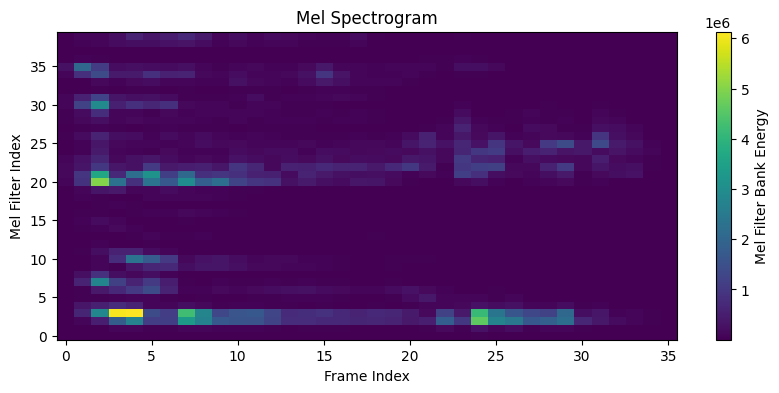

In [28]:
# Print the array after applying the Mel filter bank
print("Array after Mel Filter Bank:")
print(mel_energy)

#  Visualize the result as a 2D plot (Mel spectrogram)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.imshow(mel_energy, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Mel Filter Bank Energy')
plt.title("Mel Spectrogram")
plt.xlabel("Frame Index")
plt.ylabel("Mel Filter Index")
plt.show()

Log Mel Spectrogram (Logarithmic Scale of Mel Filter Bank Energy)

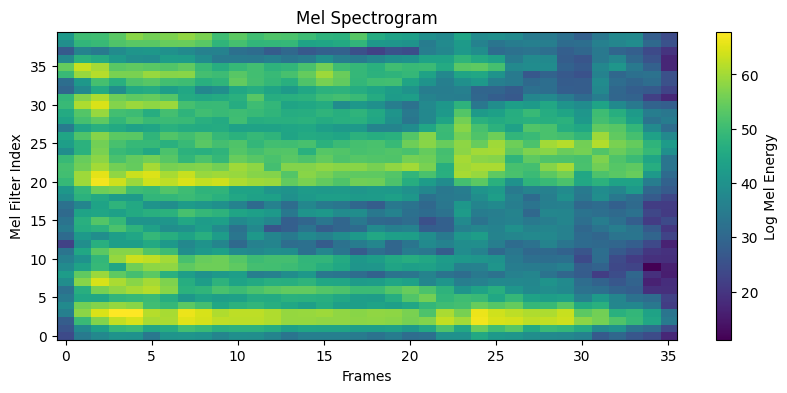

In [29]:
plt.figure(figsize=(10, 4))
plt.imshow(10 * np.log10(mel_energy + 1e-10), aspect='auto', origin='lower')
plt.colorbar(label='Log Mel Energy')
plt.xlabel("Frames")
plt.ylabel("Mel Filter Index")
plt.title("Mel Spectrogram")
plt.show()

Array after Log:
[[ 5.50135542  7.94374492  8.67555555 ...  6.1368901   5.61831603
   4.03140281]
 [ 5.98324605  8.76925943  9.96583012 ...  7.66803004  7.21417206
   5.42571008]
 [ 6.4364284  11.41319111 13.17140389 ... 11.32980498 10.31466599
   7.87826358]
 ...
 [ 6.25602673  8.39773972  7.87816416 ...  6.50307966  5.51881809
   4.51065385]
 [ 9.04053279 11.17368105 11.38944284 ...  8.8973951   7.02372524
   5.83688623]
 [ 9.63017018 11.55928221 11.60772612 ...  8.71000549  6.47039172
   5.57108197]]


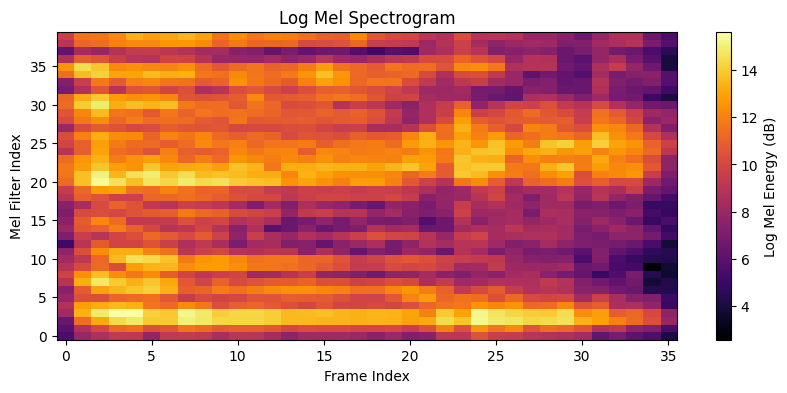

In [30]:
# Apply logarithm safely
mel_energy = np.where(mel_energy == 0, np.finfo(float).eps, mel_energy)
log_mel_energy = np.log(mel_energy)

# Print the array after applying log
print("Array after Log:")
print(log_mel_energy)

# Visualize the result (Log Mel Spectrogram)
plt.figure(figsize=(10, 4))
plt.imshow(log_mel_energy, aspect='auto', origin='lower', cmap='inferno', interpolation='none')
plt.colorbar(label='Log Mel Energy (dB)')
plt.title("Log Mel Spectrogram")
plt.xlabel("Frame Index")
plt.ylabel("Mel Filter Index")
plt.show()


# Step 8 Discrete Cosine Transform

In [31]:
from scipy.fftpack import dct

num_mfcc = 13
mfcc = dct(log_mel_energy, type=2, axis=1, norm='ortho')[:, :num_mfcc]
print("MFCC shape:", mfcc.shape)
print("First few MFCC vectors:")
print(mfcc) 


MFCC shape: (40, 13)
First few MFCC vectors:
[[ 4.88932632e+01  2.29886661e+00 -2.62718908e+00  2.60838792e+00
  -5.27193605e+00  6.11365603e-01 -9.23021409e-01 -1.13060652e+00
  -7.91064007e-01  3.43555062e-01 -1.66918182e+00 -1.11243279e+00
  -4.08760607e-01]
 [ 6.10411817e+01  1.43185556e+00 -3.89926145e+00  2.38456252e+00
  -6.41336064e+00  2.27110255e-01 -2.04365534e+00 -9.54475227e-01
  -1.79371803e+00 -1.71589832e-01 -1.80622249e+00 -1.24284207e+00
  -9.77064811e-01]
 [ 7.99223133e+01  1.19160644e+00 -4.74320937e+00  1.08945874e+00
  -7.28101809e+00 -1.91647918e-01 -3.43531781e+00 -1.37323887e+00
  -2.54912735e+00 -7.36927498e-01 -2.71887872e+00 -1.40517205e+00
  -1.61566912e+00]
 [ 8.01437636e+01  4.07595417e+00 -3.28475600e+00  2.06757492e+00
  -5.94029449e+00  9.11193396e-01 -3.01403587e+00 -1.53838957e+00
  -1.85717017e+00 -1.02018490e+00 -2.94700413e+00 -1.32196202e+00
  -1.63832922e+00]
 [ 6.52010380e+01  4.11227652e+00 -5.97437672e-01  5.41663145e+00
  -4.90249063e+00  1.

In [44]:
import os
import numpy as np
import scipy.io.wavfile as wav
import librosa
import librosa.filters
from scipy.fftpack import dct
import pandas as pd

# Parameters
fs = 16000
frame_size = 0.025
frame_stride = 0.01
NFFT = 512
num_mel_filters = 26
num_mfcc = 13
output_csv = "mfcc_features.csv"

# Function to extract MFCC from a WAV file
def extract_mfcc(filepath):
    sr, signal = wav.read(filepath)
    if len(signal.shape) > 1:
        signal = signal[:, 0]
    signal = signal / np.max(np.abs(signal))

    # Pre-emphasis
    alpha = 0.97
    emphasized = np.append(signal[0], signal[1:] - alpha * signal[:-1])

    # Framing
    frame_length = int(fs * frame_size)
    frame_step = int(fs * frame_stride)
    num_frames = int(np.ceil((len(emphasized) - frame_length) / frame_step)) + 1
    pad_length = (num_frames - 1) * frame_step + frame_length
    pad_signal = np.append(emphasized, np.zeros(pad_length - len(emphasized)))
    frames = np.lib.stride_tricks.as_strided(
        pad_signal,
        shape=(num_frames, frame_length),
        strides=(frame_step * pad_signal.itemsize, pad_signal.itemsize)
    )

    # Windowing
    hamming = np.hamming(frame_length)
    windowed_frames = frames * hamming

    # FFT and Power Spectrum
    fft_frames = np.fft.rfft(windowed_frames, NFFT)
    power_spec = (1.0 / NFFT) * (np.abs(fft_frames) ** 2)

    # Mel Filter Bank
    mel_bank = librosa.filters.mel(sr=fs, n_fft=NFFT, n_mels=num_mel_filters)
    mel_energy = np.dot(mel_bank, power_spec.T)
    mel_energy = np.where(mel_energy == 0, np.finfo(float).eps, mel_energy)
    log_mel_energy = np.log(mel_energy)

    # MFCC
    mfcc = dct(log_mel_energy, type=2, axis=1, norm='ortho')[:, :num_mfcc]

    # Flattened MFCC matrix to 1D to get overall stats
    mfcc_flat = mfcc.flatten()
    return np.mean(mfcc, axis=0), np.mean(mfcc_flat), np.std(mfcc_flat), np.min(mfcc_flat), np.max(mfcc_flat)

# Folder containing WAV files
wav_folder = "converted_wav"

# Extract MFCCs for all WAV files and add label + global stats
all_rows = []
for root, _, files in os.walk(wav_folder):
    for file in files:
        if file.lower().endswith(".wav"):
            filepath = os.path.join(root, file)
            try:
                mfcc_features, global_mean, global_std, global_min, global_max = extract_mfcc(filepath)
                label = os.path.splitext(file)[0][0].upper()
                row = [label] + list(mfcc_features) + [global_mean, global_std, global_min, global_max]
                all_rows.append(row)
            except Exception as e:
                print(f"⚠️ Error processing {filepath}: {e}")

# Prepare column names
mfcc_cols = [f"mfcc_{i+1}" for i in range(num_mfcc)]
stat_cols = ['mfcc_overall_mean', 'mfcc_overall_std', 'mfcc_overall_min', 'mfcc_overall_max']
columns = ['label'] + mfcc_cols + stat_cols

# Create DataFrame
new_df = pd.DataFrame(all_rows, columns=columns)

# Append to existing CSV if found
if os.path.exists(output_csv):
    existing_df = pd.read_csv(output_csv)
    combined_df = pd.concat([existing_df, new_df], ignore_index=True)
else:
    combined_df = new_df

# Sort and save
combined_df = combined_df.sort_values(by='label').reset_index(drop=True)
combined_df.to_csv(output_csv, index=False)

print(f"✅ Features + global stats saved to '{output_csv}' — total rows: {len(combined_df)}")


✅ Features + global stats saved to 'mfcc_features.csv' — total rows: 1400


## Model

In [38]:
import os
import numpy as np
import librosa
import pandas as pd

# Parameters
fs = 16000
num_mfcc = 13
output_csv = "mfcc_librosa_features.csv"
wav_folder = "converted_wav"

# Function to extract global MFCC stats using librosa
def extract_mfcc_librosa(filepath):
    y, sr = librosa.load(filepath, sr=fs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)

    # Mean of each MFCC (13 features)
    mfcc_means = np.mean(mfcc, axis=1)

    # Flatten all MFCC values for global stats
    flat_mfcc = mfcc.flatten()
    global_mean = np.mean(flat_mfcc)
    global_std = np.std(flat_mfcc)
    global_min = np.min(flat_mfcc)
    global_max = np.max(flat_mfcc)

    return mfcc_means, global_mean, global_std, global_min, global_max

# Loop over all files
all_rows = []
for root, _, files in os.walk(wav_folder):
    for file in files:
        if file.lower().endswith(".wav"):
            filepath = os.path.join(root, file)
            try:
                mfcc_means, gmean, gstd, gmin, gmax = extract_mfcc_librosa(filepath)

                # Extract label from filename
                label = os.path.splitext(file)[0][0].upper()

                row = [label] + list(mfcc_means) + [gmean, gstd, gmin, gmax]
                all_rows.append(row)
            except Exception as e:
                print(f"⚠️ Error processing {filepath}: {e}")

# Column headers
columns = ['label'] + [f"mfcc_{i+1}_mean" for i in range(num_mfcc)] + ['mfcc_overall_mean', 'mfcc_overall_std', 'mfcc_overall_min', 'mfcc_overall_max']

# Build DataFrame
df = pd.DataFrame(all_rows, columns=columns)

# Save to CSV
df.to_csv(output_csv, index=False)
print(f"✅ Saved {len(df)} samples to '{output_csv}' using librosa MFCC + global stats")


/home/tala/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2032
  warnings.warn(


✅ Saved 1400 samples to 'mfcc_librosa_features.csv' using librosa MFCC + global stats


In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# 1. Load the dataset
df = pd.read_csv("mfcc_features.csv")

# 2. Separate features and labels
X = df.drop("label", axis=1)
y = df["label"]

# 3. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.2f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 6. Save the model
joblib.dump(model, "random_forest_model.pkl")
print("✅ Model saved to 'random_forest_model.pkl'")


✅ Accuracy: 0.90

📊 Classification Report:
               precision    recall  f1-score   support

           A       0.92      0.87      0.89       105
           B       0.83      0.94      0.89        90
           C       0.90      0.94      0.92        83
           D       0.90      0.93      0.91        85
           E       0.92      0.95      0.93        74
           F       0.92      0.95      0.93        91
           G       0.92      0.79      0.85        85
           H       0.90      0.91      0.91        69
           I       0.91      0.87      0.89        77
           J       0.85      0.81      0.83        81

    accuracy                           0.90       840
   macro avg       0.90      0.90      0.89       840
weighted avg       0.90      0.90      0.89       840


🧩 Confusion Matrix:
 [[91  6  4  0  2  0  0  2  0  0]
 [ 1 85  2  0  2  0  0  0  0  0]
 [ 2  2 78  0  0  0  0  0  0  1]
 [ 0  3  0 79  1  2  0  0  0  0]
 [ 1  0  0  0 70  1  0  0  2  0]
 [ 1  0  0

In [40]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# 1. Load the dataset
df = pd.read_csv("mfcc_librosa_features.csv")

# 2. Separate features and labels
X = df.drop("label", axis=1)
y = df["label"]

# 3. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.2f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 6. Save the model
joblib.dump(model, "random_forest_model.pkl")
print("✅ Model saved to 'random_forest_model.pkl'")


✅ Accuracy: 0.87

📊 Classification Report:
               precision    recall  f1-score   support

           A       0.95      0.83      0.89        24
           B       0.71      0.85      0.77        26
           C       0.83      0.86      0.84        28
           D       0.82      0.75      0.78        24
           E       0.97      0.94      0.95        31
           F       0.96      0.92      0.94        26
           G       0.70      1.00      0.82        23
           H       0.92      0.88      0.90        40
           I       0.93      0.96      0.94        26
           J       0.96      0.72      0.82        32

    accuracy                           0.87       280
   macro avg       0.87      0.87      0.87       280
weighted avg       0.88      0.87      0.87       280


🧩 Confusion Matrix:
 [[20  2  0  0  0  0  0  1  0  1]
 [ 0 22  2  2  0  0  0  0  0  0]
 [ 0  4 24  0  0  0  0  0  0  0]
 [ 0  0  1 18  1  0  1  2  1  0]
 [ 0  0  0  1 29  1  0  0  0  0]
 [ 0  2  0

In [48]:
import sounddevice as sd
from scipy.io.wavfile import write

# Settings
fs = 16000  # Sampling frequency
duration = 2  # seconds
filename = "recorded.wav"

print("🎙️ Recording...")
recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='int16')
sd.wait()
write(filename, fs, recording)
print("✅ Recording saved to 'recorded.wav'")


🎙️ Recording...
✅ Recording saved to 'recorded.wav'


In [ ]:
import os
import numpy as np
import librosa
import pandas as pd

# إعدادات
num_mfcc = 13
output_csv = "mfcc_features_104.csv"
wav_folder = "converted_wav"

def extract_all_features(filepath):
    y, sr = librosa.load(filepath, sr=16000)
    y = y / np.max(np.abs(y))

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    def agg_stats(matrix):
        return np.concatenate([
            np.mean(matrix, axis=1),
            np.std(matrix, axis=1),
            np.min(matrix, axis=1),
            np.max(matrix, axis=1)
        ])
    
    def agg_deltas(matrix):
        return np.concatenate([
            np.mean(matrix, axis=1),
            np.std(matrix, axis=1)
        ])
    
    mfcc_stats = agg_stats(mfcc)         # 13*4 = 52
    delta_stats = agg_deltas(delta)      # 13*2 = 26
    delta2_stats = agg_deltas(delta2)    # 13*2 = 26

    return np.concatenate([mfcc_stats, delta_stats, delta2_stats])  # = 104

# تجميع كل الملفات
all_rows = []
for root, _, files in os.walk(wav_folder):
    for file in files:
        if file.endswith(".wav"):
            try:
                filepath = os.path.join(root, file)
                features = extract_all_features(filepath)
                label = os.path.splitext(file)[0][0].upper()
                if label.isalpha() and len(label) == 1:
                    row = [label] + list(features)
                    all_rows.append(row)
                else:
                    print("❌ Skipping file with invalid label:", file)
            except Exception as e:
                print("⚠️ Error with file:", file, "->", e)

# أسماء الأعمدة
columns = ['label']
columns += [f"mfcc_{i+1}_{stat}" for stat in ['mean', 'std', 'min', 'max'] for i in range(num_mfcc)]
columns += [f"delta_mfcc_{i+1}_{stat}" for stat in ['mean', 'std'] for i in range(num_mfcc)]
columns += [f"delta2_mfcc_{i+1}_{stat}" for stat in ['mean', 'std'] for i in range(num_mfcc)]

# حفظ البيانات
df = pd.DataFrame(all_rows, columns=columns)
df = df.sort_values('label').reset_index(drop=True)
df.to_csv(output_csv, index=False)
print(f"✅ Saved {len(df)} samples with 104 features to '{output_csv}'")


✅ Extracted feature vector of length: 17
[-2.04047073e+02  1.29710678e+02  5.19817543e+01  4.95244865e+01
  1.87245941e+01  3.43291512e+01  8.95255387e-01  1.56171465e+01
 -8.38138580e-01  1.63056450e+01  1.87956437e-01  1.11367683e+01
  3.29780984e+00  9.75584602e+00  7.13627472e+01 -2.23639084e+02
  1.50278564e+02]


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1. تحميل البيانات
df = pd.read_csv("mfcc_features_104.csv")  # يجب أن يحتوي على label + 104 عمود

# 2. تشفير الحروف لأرقام
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# 3. تقسيم البيانات إلى ميزات و تسميات
X = df.drop(columns=['label', 'label_encoded']).values
y = df['label_encoded'].values

# 4. تطبيع البيانات
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)

# 5. إعادة تشكيل البيانات إلى (عينات، خطوات زمنية، ميزات)
X = X.reshape(-1, 13, 8)  # 13 steps, 8 features لكل خطوة => 13x8 = 104

# 6. تقسيم إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. بناء النموذج
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(13, 8)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 8. تدريب النموذج
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1)

# 9. اختبار الدقة
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test accuracy: {test_acc:.2f}")


✅ Model trained.
🔠 Predicted letter: H


In [ ]:

import librosa
import numpy as np

def extract_mfcc_features(filename):
    y, sr = librosa.load(filename, sr=16000)
    y = y / np.max(np.abs(y))
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    def agg(matrix):
        return np.concatenate([np.mean(matrix, axis=1), np.std(matrix, axis=1)])

    full = np.concatenate([agg(mfcc), agg(delta), agg(delta2)])
    return full.reshape(1, 13, 8)

# توقع على ملف جديد
features = extract_mfcc_features("aaa.wav")
predicted_index = model.predict(features).argmax()
predicted_label = label_encoder.inverse_transform([predicted_index])[0]
print("📢 الحرف المتوقع هو:", predicted_label)
